# Creating network topology with pysheds
### This code illustrated how to make a watershed or basin for a given point in a river, also assist with network topology of the river (which river segment drain into which river). It start from basic dem downloading, flow direction and accumolation.


In [42]:
# import necessary packages
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import numpy as np
import json
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoSeries

## Download the DEM from hydroshed website or MERIT hydro website
### We can then load the DEM and visualize it.

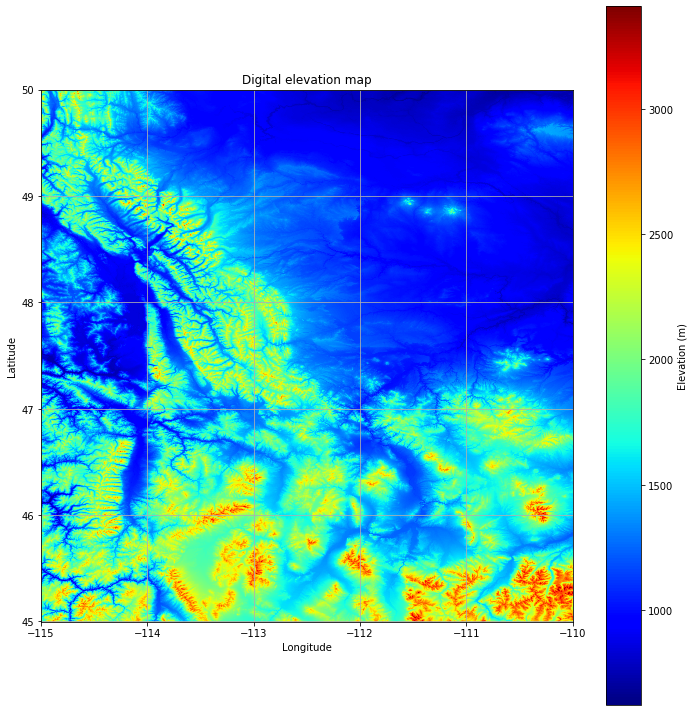

In [66]:
# read the bil or geotiff, the code reads the file and is in grid as declared name "dem"
grid = Grid.from_raster('/Users/shg096/Desktop/DEM_practice/n45w115_con_bil/n45w115_con.bil', data_name='dem')
#grid = Grid.from_raster('/Users/shg096/Desktop/DEM_practice/n45w115_con_bil/n45w115_con_tif.tif', data_name='dem')

Idinxnon = np.where(grid.dem!=-9999) # the missing values is set to -9999
plt.figure(figsize = (10,10))
plt.imshow(grid.dem.astype(float), extent=grid.extent, cmap='jet', zorder=1,
           vmin=np.min(grid.dem[Idinxnon]), vmax=np.max(grid.dem[Idinxnon]))
plt.colorbar(label='Elevation (m)') # creating the colorbar and its name and unit
plt.grid(zorder=0) # creating the grid on the map
plt.title('Digital elevation map') # creating title
plt.xlabel('Longitude') #xlable which is long
plt.ylabel('Latitude') #ylable which is lat
plt.tight_layout()
#plt.savefig('img/conditioned_dem.png', bbox_inches='tight') # in case if you would like to save the figure

## Next we should fill the depression and resolves flats for the DEM and create the flow direction

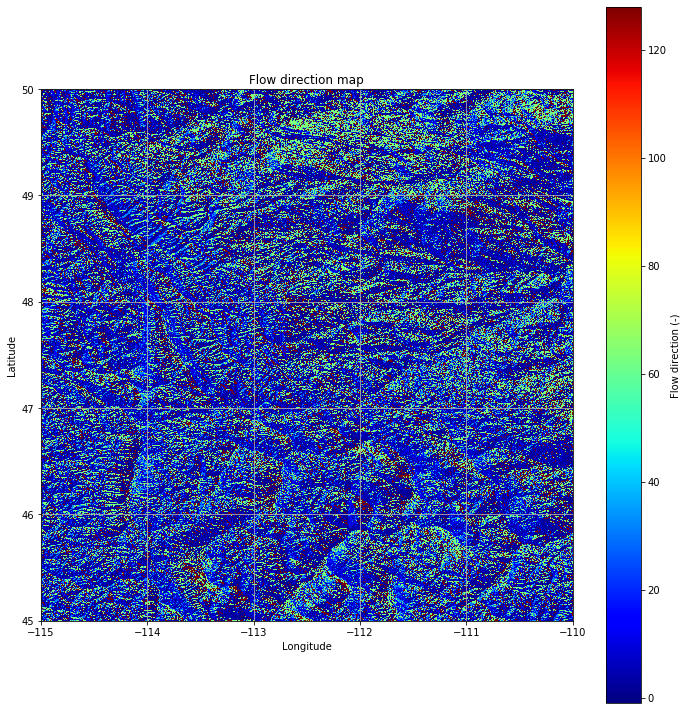

In [67]:
# fill depression of the dem, this is similar to fill processdure in GIS softwares
# it creates another data frame in the data called flooded_dem
grid.fill_depressions(data='dem', out_name='flooded_dem')

# resolve flats in the filled DEM
grid.resolve_flats('flooded_dem', out_name='inflated_dem') #resolve the flats

# Specify directional mapping
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# specifying flow direction
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

# illustrating the flow direction
plt.figure(figsize = (10,10))
plt.imshow(grid.dir.astype(int), extent=grid.extent, cmap='jet', zorder=1)
plt.colorbar(label='Flow direction (-)')
plt.grid(zorder=0)
plt.title('Flow direction map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
#plt.savefig('img/conditioned_dem.png', bbox_inches='tight')

## creating the flow accumulation

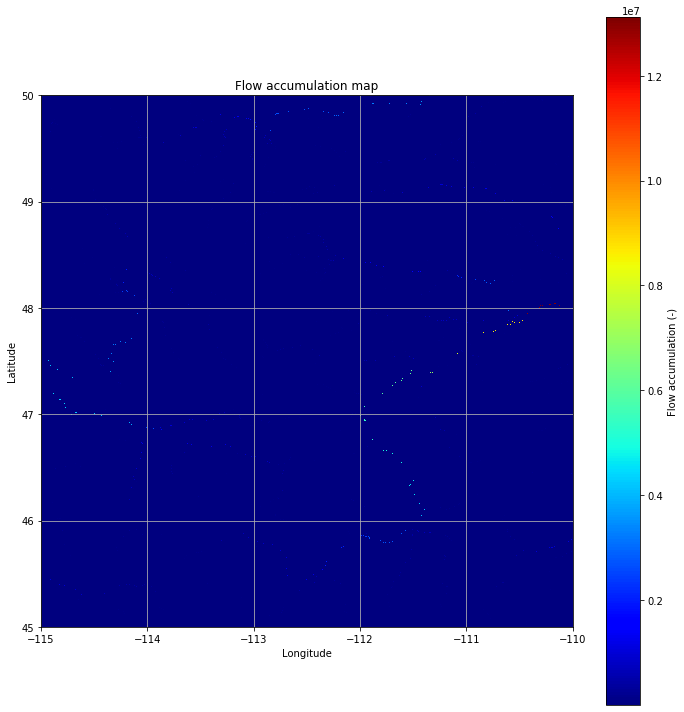

In [81]:
grid.accumulation(data='dir', dirmap=dirmap, out_name='acc')#, apply_mask=False)

plt.figure(figsize = (10,10))
plt.imshow(grid.acc.astype(float), extent=grid.extent, cmap='jet')#, zorder=1)
plt.colorbar(label='Flow accumulation (-)')
plt.grid(zorder=0)
plt.title('Flow accumulation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

## So far, we have all the neccessary raster to start basin or catchemtn deliniation

[-110.03416667] [47.81666667]


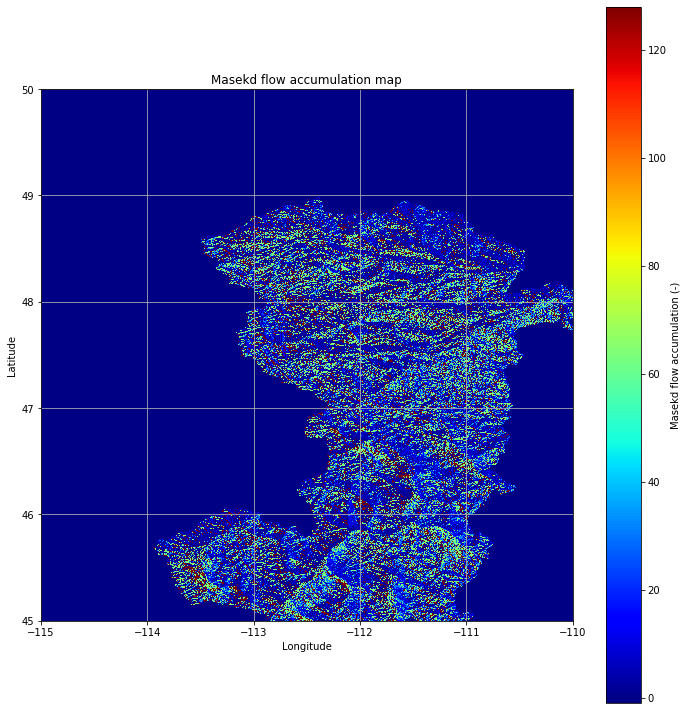

In [70]:
# providing the coordinates of the basin outlet
x, y = -110.03416666666686, 47.816666666666755
xy = np.column_stack([x, y])

# putting the outlet point exactly on the river network
new_xy = grid.snap_to_mask(grid.acc > 1000, xy, return_dist=False)
new_xs, new_ys = new_xy[:,0], new_xy[:,1]
print(new_xs, new_ys)

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')


# show the deliniated basin
plt.figure(figsize = (10,10))
plt.imshow(grid.catch.astype(int), extent=grid.extent, cmap='jet')#, zorder=1)
plt.colorbar(label='Masekd flow accumulation (-)')
plt.grid(zorder=0)
plt.title('Masekd flow accumulation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()



## now creting the river netweok based on a given threshold

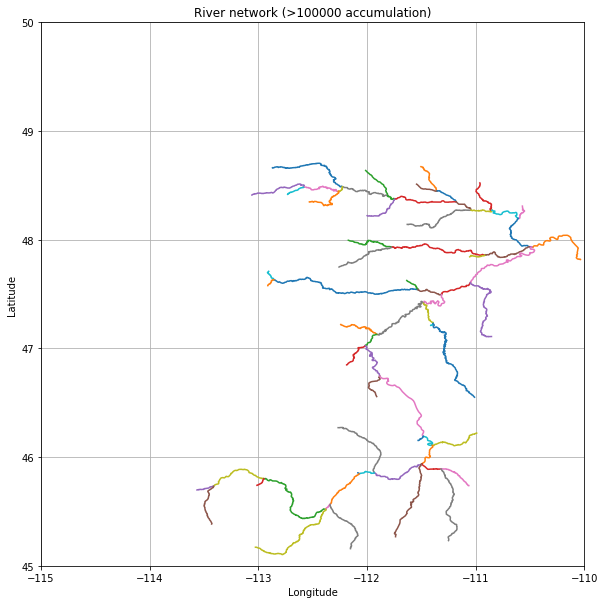

In [78]:
# extrating the river segments
branches = grid.extract_river_network(fdir='catch', acc='acc',
                                      threshold=100000, dirmap=dirmap)

# plotting the river segments
fig, ax = plt.subplots(figsize=(10,10))
plt.grid('on', zorder=0)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('River network (>100000 accumulation)')
plt.xlim(grid.bbox[0], grid.bbox[2]) # the bounding box from grid
plt.ylim(grid.bbox[1], grid.bbox[3]) # the bounding box from grid
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

# dumpt the lines into a network
with open('/Users/shg096/Desktop/DEM_practice/river_network_100000.json', 'w') as json_file:
    json.dump(branches, json_file)
# load the json and save it as a shapefile using geopandas
A = gpd.read_file('/Users/shg096/Desktop/DEM_practice/river_network_100000.json')
# save the shapefile
A.to_file('/Users/shg096/Desktop/DEM_practice/river_network_100000.shp')

## Getting the data from the river network topology and saving it into a shapefile
### The end point of each river segment identified here act like a virtual gauges. If there is additional gauges we can break a river segment into different segments (WIP).

In [79]:
# load the json file as a shapefile
A = gpd.read_file('/Users/shg096/Desktop/DEM_practice/river_network_100000.shp') # shapefile that is manupulated
# creat additional fields for network topology data
A['start_lat'] = None
A['start_lon'] = None
A['end_lat']   = None
A['end_lon']   = None
A['end_lat_b'] = None
A['end_lon_b'] = None
A['ID']        = None
A['Down_ID']   = None
A['order']     = None
A['Up_ID']     = None

# popolating the fileds
for index, row in A.iterrows():
    line = np.asarray(row['geometry'])
    #plt.plot(line[:, 0], line[:, 1])
    # note that the direction of the river segments are from downstream to upstream
    #plt.scatter(line[0,0], line[0,1], marker='x', c='k', zorder=2) # the end
    #plt.scatter(line[-1,0], line[-1,1], marker='o', c='r', zorder=2) # the start
    # populate the filed
    A['start_lat'].iloc[index] = line[-1,1] 
    A['start_lon'].iloc[index] = line[-1,0] 
    A['end_lat'].iloc[index]   = line[0,1] 
    A['end_lon'].iloc[index]   = line[0,0] 
    A['end_lat_b'].iloc[index] = line[1,1] # one before merged point not to include all the contributing area of confluence
    A['end_lon_b'].iloc[index] = line[1,0] # one before merged point not to include all the contributing area of confluence
    A['ID'].iloc[index]        = index + 1
    
    # print(A['end_lat_b'].iloc[index] , A['end_lon_b'].iloc[index])


# create a list of immidiate downstream
A['Down_ID'] = -9999
for index, row in A.iterrows():
    # get the end lat, lon of a river segment
    end_lat = A['end_lat'].iloc[index] 
    end_lon = A['end_lon'].iloc[index] 
    # find which degment start with that lat, lon
    indy = A.index[A['start_lat'] == end_lat].tolist()
    indx = A.index[A['start_lon'] == end_lon].tolist()
    # find the ind of indy and indx
    ind = list(set(indy).intersection(indx))
    # assign the list of downstream segment to the field if no downstream -9999
    if str(ind).strip('[]') != '':
        A['Down_ID'].iloc[index] = A['ID'].iloc[int(str(ind).strip('[]'))]
    else:
        A['Down_ID'].iloc[index] = -9999

# creat a list of immidiate upstream
for index, row in A.iterrows():
    # get the ID of the river segment
    ID = A['ID'].iloc[index] 
    # find the immidate upstream
    ind = A.index[A['Down_ID'] == ID]
    indup = A['ID'].iloc[ind].tolist()
    # assign the upstream list
    A['Up_ID'].iloc[index] = str(indup)


# save the shapefile
A.to_file('/Users/shg096/Desktop/DEM_practice/river_network_100000.shp')

# save virtual gauges as points
yc = A['end_lat_b']
xc = A['end_lon_b']
pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])
pts.to_file('/Users/shg096/Desktop/DEM_practice/river_network_100000_virtual_gauges.shp')

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Here is the heavy lift, we create a basin for each virtual gauges (the downstream point of a river segment) and use that to create the basin area
### For the river segments with stream order more than 1, the upstream basins should be carved out of the basin

1
FID                                                          0
geometry     LINESTRING (-112.225833 48.486667, -112.226667...
start_lat                                                48.66
start_lon                                             -112.869
end_lat                                                48.4867
end_lon                                               -112.226
end_lat_b                                              48.4867
end_lon_b                                             -112.227
ID                                                           1
Down_ID                                                      8
order                                                     None
Up_ID                                                       []
Name: 0, dtype: object
----------------------
1
----------------------
first order []
1.0
2
FID                                                          1
geometry     LINESTRING (-111.353333 48.448333, -111.354167...
start_lat               

1
----------------------
first order []
1.0
11
FID                                                         10
geometry     LINESTRING (-111.179167 48.348333, -111.179167...
start_lat                                              48.4483
start_lon                                             -111.353
end_lat                                                48.3483
end_lon                                               -111.179
end_lat_b                                              48.3492
end_lon_b                                             -111.179
ID                                                          11
Down_ID                                                     16
order                                                     None
Up_ID                                                   [2, 6]
Name: 10, dtype: object
----------------------
1
----------------------
higher order [2, 6]
2
6
1.0
12
FID                                                         11
geometry     LINESTRING (-112.2

1
----------------------
higher order [4, 19]
4
19
1.0
21
FID                                                         20
geometry     LINESTRING (-110.5075 47.934167, -110.508333 4...
start_lat                                              48.1942
start_lon                                             -110.609
end_lat                                                47.9342
end_lon                                               -110.507
end_lat_b                                               47.935
end_lon_b                                             -110.508
ID                                                          21
Down_ID                                                     25
order                                                     None
Up_ID                                                 [17, 20]
Name: 20, dtype: object
----------------------
1
----------------------
higher order [17, 20]
17
20
1.0
22
FID                                                         21
geometry     LIN

1
----------------------
first order []
1.0
31
FID                                                         30
geometry     LINESTRING (-111.528333 47.540833, -111.529167...
start_lat                                              47.6308
start_lon                                             -112.856
end_lat                                                47.5408
end_lon                                               -111.528
end_lat_b                                              47.5417
end_lon_b                                             -111.529
ID                                                          31
Down_ID                                                     36
order                                                     None
Up_ID                                                 [30, 32]
Name: 30, dtype: object
----------------------
1
----------------------
higher order [30, 32]
30
32
1.0
32
FID                                                         31
geometry     LINESTRING (-1

1
----------------------
first order []
1.0
41
FID                                                         40
geometry     LINESTRING (-111.3925 47.228333, -111.391667 4...
start_lat                                                46.55
start_lon                                              -111.01
end_lat                                                47.2283
end_lon                                               -111.392
end_lat_b                                              47.2275
end_lon_b                                             -111.392
ID                                                          41
Down_ID                                                     39
order                                                     None
Up_ID                                                       []
Name: 40, dtype: object
----------------------
1
----------------------
first order []
1.0
42
FID                                                         41
geometry     LINESTRING (-111.91 47.1283

1
----------------------
higher order [49, 52]
49
52
1.0
51
FID                                                         50
geometry     LINESTRING (-111.480833 46.19, -111.481667 46....
start_lat                                              46.1525
start_lon                                             -111.529
end_lat                                                  46.19
end_lon                                               -111.481
end_lat_b                                              46.1892
end_lon_b                                             -111.482
ID                                                          51
Down_ID                                                     47
order                                                     None
Up_ID                                                       []
Name: 50, dtype: object
----------------------
1
----------------------
first order []
1.0
52
FID                                                         51
geometry     LINESTRING (-1

1
----------------------
higher order [61, 62]
61
62
1.0
61
FID                                                         60
geometry     LINESTRING (-112.0725 45.845833, -112.073333 4...
start_lat                                               45.855
start_lon                                             -112.083
end_lat                                                45.8458
end_lon                                               -112.073
end_lat_b                                              45.8467
end_lon_b                                             -112.073
ID                                                          61
Down_ID                                                     60
order                                                     None
Up_ID                                                       []
Name: 60, dtype: object
----------------------
1
----------------------
first order []
1.0
62
FID                                                         61
geometry     LINESTRING (-1

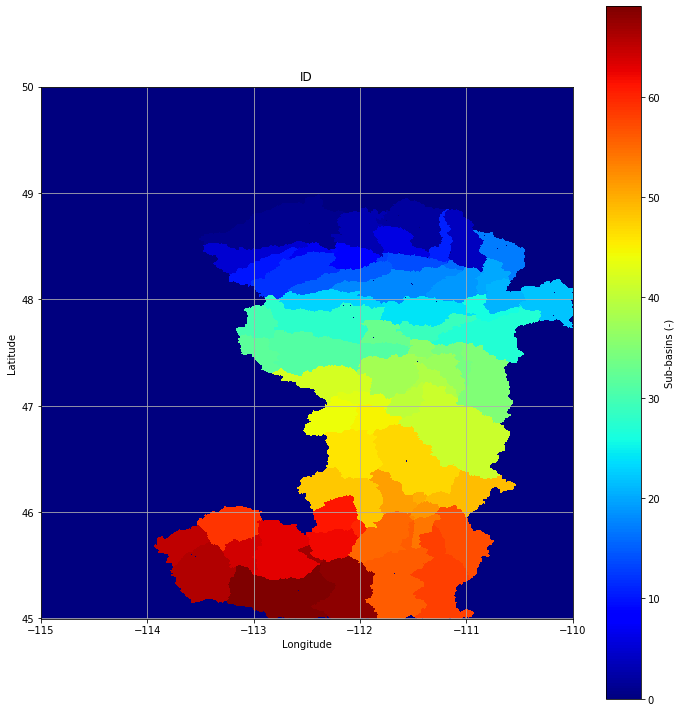

In [80]:
# creat a zero grid similar to the shape of the DEM
z1 = np.zeros(grid.shape)

# loop over each segment of the river
for index, row in A.iterrows():
    cat_ID = A['ID'].iloc[index] # get the ID of that river segment
    print(cat_ID)
    print(A.iloc[index])
    print('----------------------')
    # create subbasin of that river segment
    c_2 = grid.catchment(A['end_lon_b'].iloc[index], A['end_lat_b'].iloc[index], \
                       data='dir', dirmap=dirmap, xytype='label', inplace=False)
    c_2 = (c_2 != 0).astype(int)
    print(c_2.max())
    print('----------------------')
    if A['Up_ID'].iloc[index]=='[]': # in case no upstream, first order river segment
        print('first order', A['Up_ID'].iloc[index])
        c_1 = np.zeros(grid.shape)  # no upstream area should be carved from the deliniated sub-basin
    else:
        print('higher order', A['Up_ID'].iloc[index])
        c_1_temp = np.zeros(grid.shape)
        # find the index of the upstream area in the
        s=A['Up_ID'].iloc[index] # get the string of upstream id onjects
        # remove 
        s = s.replace('[', '')
        s = s.replace(']', '')
        up_ids = np.fromstring(s, dtype=int, sep=',')
        # loop over upstream segments and create the model
        for i in np.arange(up_ids.size):
            print(up_ids[i])
            #find the index of the upstream and creat the basin
            index_local = A.index[A['ID'] == up_ids[i]].tolist()
            index_local = int(index_local[0]) # the local index of upstream segment
            c_1 = grid.catchment(A['end_lon_b'].iloc[index_local], A['end_lat_b'].iloc[index_local], \
                                 data='dir', dirmap=dirmap, xytype='label', inplace=False)
            c_1_temp = c_1_temp + (c_1 != 0).astype(int)
        c_1 = c_1_temp
    # carve the upstream area from the river segment
    c = c_2 - c_1
    print(c.max())
    z1 += cat_ID * (c != 0).astype(int)

#

# Add z1 to grid
grid.add_gridded_data(z1, data_name='z1', affine=grid.affine,
                      shape=z1.shape, crs=grid.crs, nodata=np.nan)

# Write to raster
grid.to_raster('z1', '/Users/shg096/Desktop/DEM_practice/z1.tif', view=False)

# show the deliniated sub-basin
plt.figure(figsize = (10,10))
plt.imshow(grid.z1.astype(int), extent=grid.extent, cmap='jet')#, zorder=1)
plt.colorbar(label='Sub-basins (-)')
plt.grid(zorder=0)
plt.title('ID')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()


## Finally saving the subbasin as a geotiff
## If desirable we can keep the lat/lon of each raster point to use for getting the DEM, correctin the actual gauges location, etc

In [94]:
# Write FAC to raster
Z2 = np.array(grid.dir.astype(float))
grid.add_gridded_data(Z2, data_name='Z2', affine=grid.affine,
                     shape=z1.shape, crs=grid.crs, nodata=np.nan)
grid.to_raster('Z2', '/Users/shg096/Desktop/DEM_practice/dir.tif', view=False)

# get the coordinate of the DEM
dem_coords = grid.dem.coords
# reshape the coordinate to the DEM raster
dem_coords_reshaped = [dem_coords[:,0].reshape(grid.dem.shape),
                       dem_coords[:,1].reshape(grid.dem.shape)]
# put it in a data array
dem_coords_reshaped = np.array (dem_coords_reshaped)
lat = dem_coords_reshaped[0,:,:] # get the lat values,
lon = dem_coords_reshaped[1,:,:] # get the lon values,

# Add lat to grid
grid.add_gridded_data(lat, data_name='lat', affine=grid.affine,
                      shape=z1.shape, crs=grid.crs, nodata=np.nan)
# Write as raster
grid.to_raster('lat', '/Users/shg096/Desktop/DEM_practice/lat.tif', view=False)

# Add lon to grid
grid.add_gridded_data(lon, data_name='lon', affine=grid.affine,
                      shape=z1.shape, crs=grid.crs, nodata=np.nan)
# Write as raster
grid.to_raster('lon', '/Users/shg096/Desktop/DEM_practice/lon.tif', view=False)

## opening the tif file and converting it to a shapefile if needed

In [39]:
#import gdal, ogr
from osgeo import gdal, ogr
import sys
# this allows GDAL to throw Python Exceptions
#gdal.UseExceptions()
src_ds = gdal.Open( '/Users/shg096/Desktop/DEM_practice/z1.tif' )
srcband = src_ds.GetRasterBand(1)
dst_layername = '/Users/shg096/Desktop/DEM_practice/z2.shp'
drv = ogr.GetDriverByName('ESRI Shapefile')
dst_ds = drv.CreateDataSource(dst_layername)
dst_layer = dst_ds.CreateLayer(dst_layername , srs=None)
fd = ogr.FieldDefn('DN', ogr.OFTInteger)
dst_layer.CreateField(fd)
dst_field = dst_layer.GetLayerDefn().GetFieldIndex('DN')
gdal.Polygonize(srcband, None, dst_layer, dst_field, [], callback=None)

0

In [35]:
import os
import gdal
import numpy as np
import matplotlib.pyplot as plt

file = '/Users/shg096/Desktop/DEM_practice/n45w115_con_bil/n45w115_con_tif.tif'
ds = gdal.Open(file)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
[cols, rows] = arr.shape

In [36]:
outFileName = '/Users/shg096/Desktop/DEM_practice/subbasins.tif'
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create(outFileName, rows, cols, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(z1)
outdata.GetRasterBand(1).SetNoDataValue(0)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None



In [187]:
print(z1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<class 'list'>
<class 'numpy.ndarray'>
(2, 6000, 6000)


In [ ]:



# for getting the bil information 
import gdal
gdal.GetDriverByName('EHdr').Register()
ds = gdal.Open('/Users/shg096/Desktop/DEM_practice/n45w115_con_bil/n45w115_con.bil')
band = ds.GetRasterBand(1)
data = band.ReadAsArray()
[cols, rows] = arr.shape

image = plt.imshow(data)

In [ ]:
#filling the holes from the flatten function 
#https://stackoverflow.com/questions/41550979/fill-holes-with-majority-of-surrounding-values-python
#https://github.com/mdbartos/pysheds/issues/90

In [ ]:
# to split a line with nearest distnace
https://gis.stackexchange.com/questions/268518/split-line-by-nearest-points-using-geopandas
